## 1. EDA

This is for an interview:
~~~
We'd like you to attempt this Kaggle assessment, and if you can take two approaches to it: one being an LLM-based approach, and a non-LLM based approach. 
Please note you also must cite sources - using others' kaggles or snippets of code from online is absolutely fine, but we cannot accept any form of plagiarism.
~~~
~~For LLM code generation, just mark sections of code whose genesis or alternation involved it (expect specifically Copilot).~~

**^ not relevant as my copilot license ran out lol**

In [2]:
# Downloaded a bunch of corpuses / nltk / spacy stuff as an fyi
# python -m spacy download en_core_web_sm, md, lg, trf

In [221]:
from IPython.display import display

In [485]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/Spam_SMS.csv')

In [461]:
df.columns = df.columns.map(str.lower)

In [243]:
display(df['class'].value_counts())
display(df[df['message'] == ''].count())
display(df.isnull().sum())

class
ham     4827
spam     747
Name: count, dtype: int64

class      0
message    0
dtype: int64

class      0
message    0
dtype: int64

In [32]:
df['char_len'] = df['message'].apply(len)
df['word_len'] = df['message'].apply(str.split).apply(len)

In [10]:
import seaborn as sns

<Axes: xlabel='char_len', ylabel='Count'>

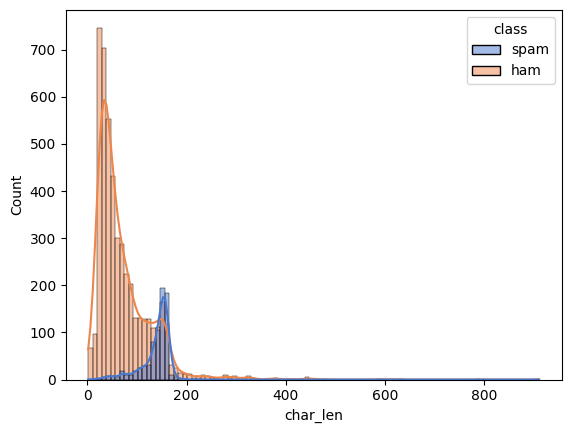

In [18]:
sns.histplot(data=df, x='char_len', hue='class', bins=100, kde=True, palette='muted', hue_order=["spam", "ham"])

<Axes: xlabel='word_len', ylabel='Count'>

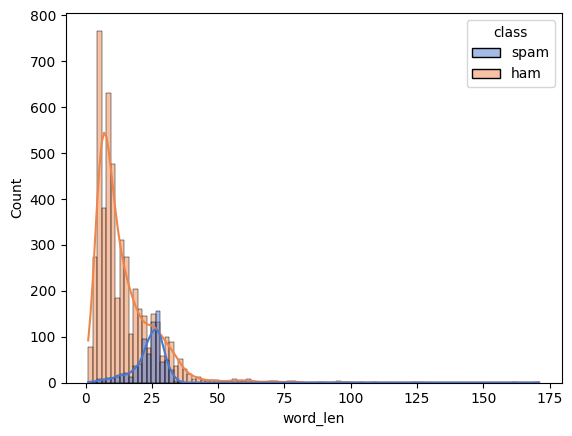

In [19]:
sns.histplot(data=df, x='word_len', hue='class', bins=100, kde=True, palette='muted', hue_order=["spam", "ham"])

### Notes
Benford's law clear ^ 😍 love to see it.

Non-LLM Ideas:
- Shannon Entropy / Cross-Entropy?
- TF-IDF / Tokenization / Vectorization by default
- Naive Bayes
- K-NN
- XGBoost
- More, but let's stick with this

LLM Ideas:
- Distilbert
- Roberta

## 2. Some Extra Dataset Prep

#### Just using SMS dataset

In [486]:
df.columns = ['label', 'message']
df['message'] = df['message'].astype(str)
df['label'] = df['label'].apply(lambda x: 1 if x=='spam' else 0)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['label'], test_size=0.2)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

counter = CountVectorizer(max_features=5000, tokenizer=tokenizer.tokenize)
# # TODO: test out different ngram ranges?# Can't use vectorizer since we need to transform y data too
counter = counter.fit(X_train)
x_train = counter.transform(X_train)
x_test = counter.transform(X_test)

tfidf_vectorizer = TfidfTransformer()
tfidf_vectorizer = tfidf_vectorizer.fit(x_train)
X_train = tfidf_vectorizer.transform(x_train)
X_test = tfidf_vectorizer.transform(x_test)

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Throwing Enron + Twitter into the mix...
Slightly different approach: use enron and telegram msgs as training data to test if our og spam is canned properly, ya feel me?

##### Enron

In [228]:
# Enron
enron_df = pd.read_csv('data/enron_spam_data.csv')

# don't wanna drop dupes for tfidf purposes
enron_df = enron_df[['Spam/Ham', 'Message']].dropna()#.drop_duplicates('Message')
enron_df.columns = ['label', 'message']

In [210]:
enron_df.label.value_counts()

label
spam    16852
ham     16493
Name: count, dtype: int64

In [146]:
enron_df['char_len'] = enron_df['message'].apply(len)
enron_df['word_len'] = enron_df['message'].apply(str.split).apply(len)

In [227]:
# Lol at the one outlier
display(pd.DataFrame(pd.cut(enron_df['char_len'], 100).value_counts()).sort_index())
# temp = pd.cut(enron_df['char_len'], 100).value_counts().reset_index()
# temp[temp['count'] > 0].sort_values(by='char_len', ascending=False)

# Out of 34K samples, 1K is > 6500 chars in length, which is arguably negligible, but interesting how the distribution is different for enron
print(f"diff: {enron_df.shape[0] - enron_df[enron_df['char_len'] < 6500].shape[0]}")
# Interesting to see what this 200K one is...
# enron_df.loc[enron_df['char_len'].idxmax()] # WSJ?

,count
char_len,
"(-227.352, 2284.52]",28005
"(2284.52, 4568.04]",3635
"(4568.04, 6851.56]",831
"(6851.56, 9135.08]",479
"(9135.08, 11418.6]",122
...,...
"(216935.4, 219218.92]",0
"(219218.92, 221502.44]",0
"(221502.44, 223785.96]",0


diff: 972


<Axes: xlabel='char_len', ylabel='Count'>

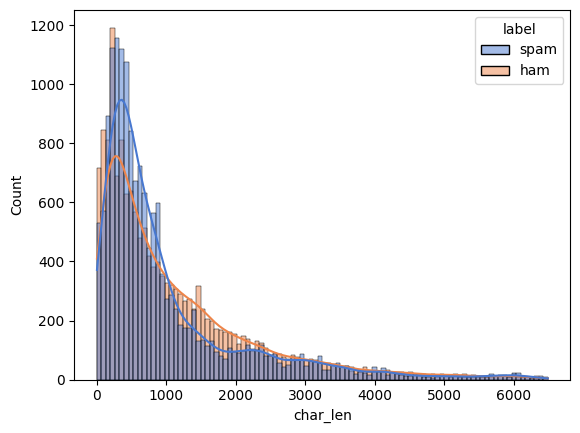

In [206]:
sns.histplot(data=enron_df[enron_df['char_len'] < 6500], x='char_len', hue='label', bins=100, kde=True, palette='muted', hue_order=['spam', 'ham'])

In [205]:
# Out of 34K samples, 1K is > 6500 chars in length, which is arguably negligible, but interesting how the distribution is different for enron
enron_df.shape[0] - enron_df[enron_df['word_len'] < 2000].shape[0]
# Interesting to see what this 200K one is...
# enron_df.loc[enron_df['char_len'].idxmax()] # WSJ?

338

<Axes: xlabel='word_len', ylabel='Count'>

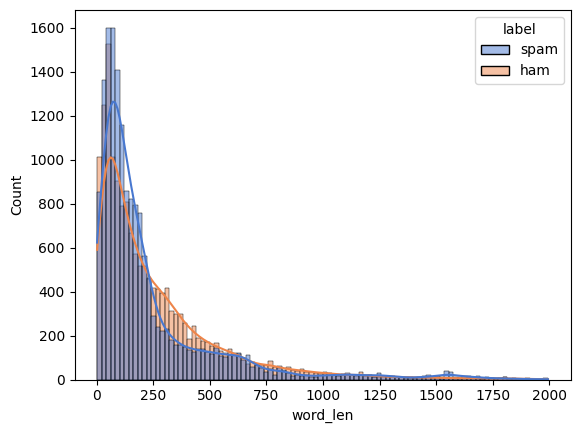

In [204]:
sns.histplot(data=enron_df[enron_df['word_len'] < 2000], x='word_len', hue='label', bins=100, kde=True, palette='muted', hue_order=["spam", "ham"])


##### Twitter

In [231]:
# Twitter
# don't wanna drop dupes for tfidf purposes
telegram_df = pd.read_csv('data/telegram_spam_ham_data.csv').dropna()#.drop_duplicates('text')
telegram_df.columns = ['label', 'message']

telegram_df.label.value_counts()

label
ham     14337
spam     6011
Name: count, dtype: int64

In [232]:
telegram_df['char_len'] = telegram_df['message'].apply(len)
telegram_df['word_len'] = telegram_df['message'].apply(str.split).apply(len)

<Axes: xlabel='char_len', ylabel='Count'>

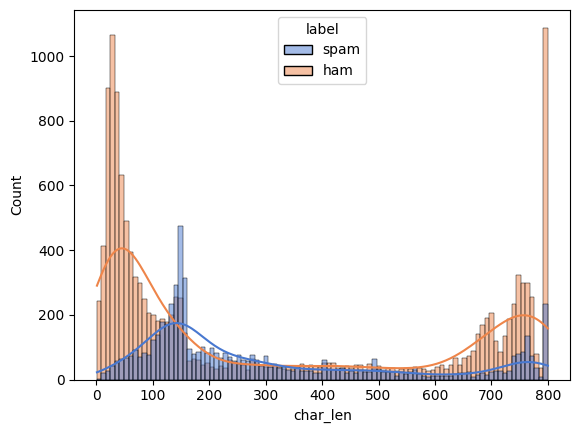

In [233]:
sns.histplot(data=telegram_df, x='char_len', hue='label', bins=100, kde=True, palette='muted', hue_order=['spam', 'ham'])

<Axes: xlabel='word_len', ylabel='Count'>

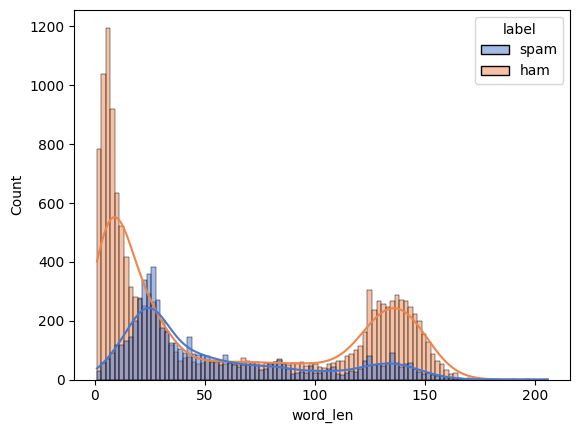

In [234]:
sns.histplot(data=telegram_df, x='word_len', hue='label', bins=100, kde=True, palette='muted', hue_order=['spam', 'ham'])

In [235]:
# Both still follow Benford's law which is what's interesting, but have different distributions than the original text one.
# Will be interesting to see impact on statistical models

##### SAVE EM

In [135]:
enron_df.to_csv('data/enron.csv')
telegram_df.to_csv('data/telegram.csv')

##### Wombo Combo V.1

**Training:** Telegram (20348), Enron (33345) - 53693 Total

**Testing** ucirvine SMS (5574)

In [515]:
### train
train_df_2 = pd.concat((enron_df, telegram_df), ignore_index=True)
train_df_2['label'] = train_df_2['label'].apply(lambda x: 1 if x=='spam' else 0)
train_df_2['message'] = train_df_2['message'].astype(str)

# OG
test_df_2 = df

X_train2, X_test2, Y_train2, Y_test2 = train_df_2['message'], test_df_2['message'], train_df_2['label'], test_df_2['label']

counter = CountVectorizer(max_features=5000, tokenizer=tokenizer.tokenize)
# # TODO: test out different ngram ranges?# Can't use vectorizer since we need to transform y data too
counter = counter.fit(X_train2)
x_train2 = counter.transform(X_train2)
x_test2 = counter.transform(X_test2)

tfidf_vectorizer = TfidfTransformer()
tfidf_vectorizer = tfidf_vectorizer.fit(x_train2)
X_train2 = tfidf_vectorizer.transform(x_train2)
X_test2 = tfidf_vectorizer.transform(x_test2)


/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Ratcliff-Obershelp distance aka Gestalt pattern matching
# https://en.wikipedia.org/wiki/Gestalt_pattern_matching
# import textdistance
# df.head()['message'].apply(lambda x: max([textdistance.ratcliff_obershelp(x,y) for y in telegram_df['text'].head()]))

# unfortunately expensive to run rn, so doing the laziest thing possible lol
# but given such different distributions, likelihood of overlap is probably very small
df['message'][df['message'].apply(lambda x: x in train_df_2['message'])]

##### Wombo Combo V.2

**Training:** 80% - taken evenly from Telegram (20348), Enron (33345), and SMS

**Testing** 20% - taken evenly from Telegram (20348), Enron (33345), and SMS

In [288]:
enron_df['origin'] = 'enron'
telegram_df['origin'] = 'telegram'
df['origin'] = 'sms'

In [522]:
totality = pd.concat((enron_df, telegram_df, df), ignore_index=True)
totality['label'] = totality['label'].apply(lambda x: 1 if x=='spam' else 0)
totality = totality[['label', 'message', 'origin']]

In [524]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(totality['message'], totality['label'], test_size=0.2)
display(totality.loc[X_train3.index].origin.value_counts()/X_train3.shape[0])

counter = CountVectorizer(max_features=5000, tokenizer=tokenizer.tokenize)
# # TODO: test out different ngram ranges?
# # Can't use vectorizer since we need to transform y data too
counter = counter.fit(X_train3)
x_train3 = counter.transform(X_train3)
x_test3 = counter.transform(X_test3)

tfidf_vectorizer = TfidfTransformer()
tfidf_vectorizer = tfidf_vectorizer.fit(x_train3)
X_train3 = tfidf_vectorizer.transform(x_train3)
X_test3 = tfidf_vectorizer.transform(x_test3)

origin
enron       0.563369
telegram    0.342311
Name: count, dtype: float64

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 3. Multinomial Bayes

#### Using Just Original UC Irvine Kaggle SMS Dataset with 80/20 split

In [490]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB()

In [499]:
val_converter = {0: "ham", 1:"spam"}

Accuracy: 0.9713004484304932
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       974
        spam       1.00      0.77      0.87       141

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



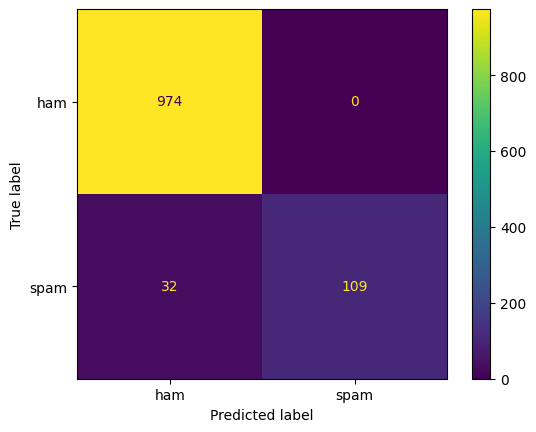

In [509]:
y_pred = [val_converter[x] for x in nb.predict(X_test)]
y_true = [val_converter[x] for x in Y_test]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

#### Using Enron + Telegram as Training, and Testing on SMS

Accuracy: 0.8010405453893075
              precision    recall  f1-score   support

         ham       0.98      0.79      0.87      4827
        spam       0.39      0.90      0.55       747

    accuracy                           0.80      5574
   macro avg       0.69      0.84      0.71      5574
weighted avg       0.90      0.80      0.83      5574



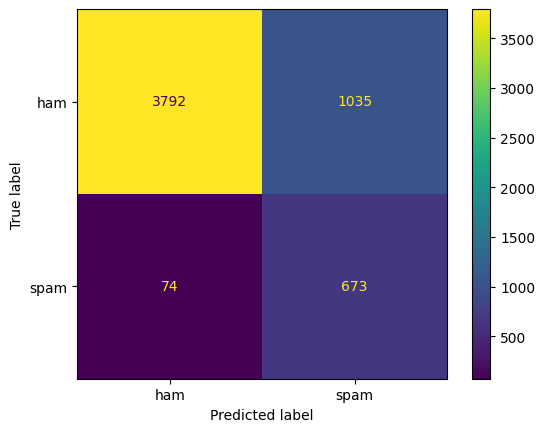

In [542]:
nb = MultinomialNB()
nb.fit(X_train2, Y_train2)

y_pred = [val_converter[x] for x in nb.predict(X_test2)]
y_true = [val_converter[x] for x in Y_test2]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

#### Using an 80/20 of all combined data sources

Accuracy: 0.9242449805972668
              precision    recall  f1-score   support

         ham       0.94      0.93      0.94      7378
        spam       0.89      0.91      0.90      4476

    accuracy                           0.92     11854
   macro avg       0.92      0.92      0.92     11854
weighted avg       0.92      0.92      0.92     11854



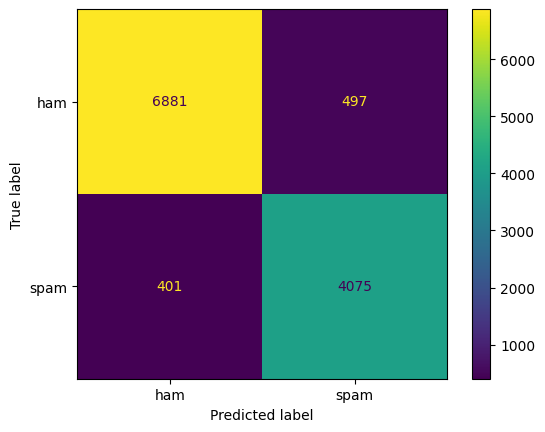

In [540]:
nb = MultinomialNB()
nb.fit(X_train3, Y_train3)

y_pred = [val_converter[x] for x in nb.predict(X_test3)]
y_true = [val_converter[x] for x in Y_test3]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

## 4. KNN

#### Using Just Original UC Irvine Kaggle SMS Dataset with 80/20 split

Accuracy: 0.9623318385650225
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       974
        spam       1.00      0.70      0.82       141

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



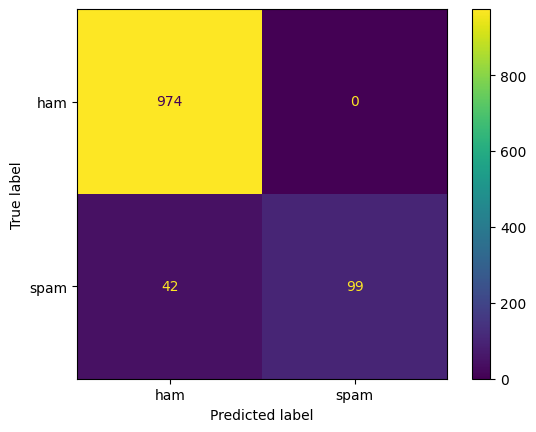

In [544]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2, metric="cosine", n_jobs=-1) # Want to use cosine because we're not animals, come on.
model.fit(X_train, Y_train)


y_pred = [val_converter[x] for x in model.predict(X_test)]
y_true = [val_converter[x] for x in Y_test]


print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

#### Using Enron + Telegram as Training, and Testing on SMS

Accuracy: 0.974524578399713
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4827
        spam       0.99      0.82      0.90       747

    accuracy                           0.97      5574
   macro avg       0.98      0.91      0.94      5574
weighted avg       0.97      0.97      0.97      5574



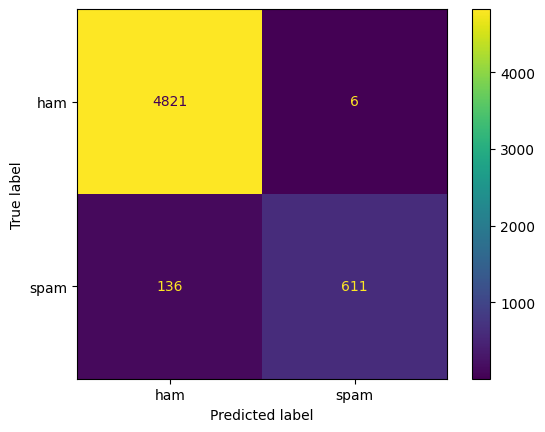

In [583]:
model = KNeighborsClassifier(n_neighbors=2, metric='cosine', n_jobs=-1)
model.fit(X_train2, Y_train2)


y_pred = [val_converter[x] for x in model.predict(X_test2)]
y_true = [val_converter[x] for x in Y_test2]


print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

#### Using an 80/20 of all combined data sources

Accuracy: 0.9233170237894381
              precision    recall  f1-score   support

         ham       0.90      0.98      0.94      7378
        spam       0.96      0.83      0.89      4476

    accuracy                           0.92     11854
   macro avg       0.93      0.90      0.92     11854
weighted avg       0.93      0.92      0.92     11854



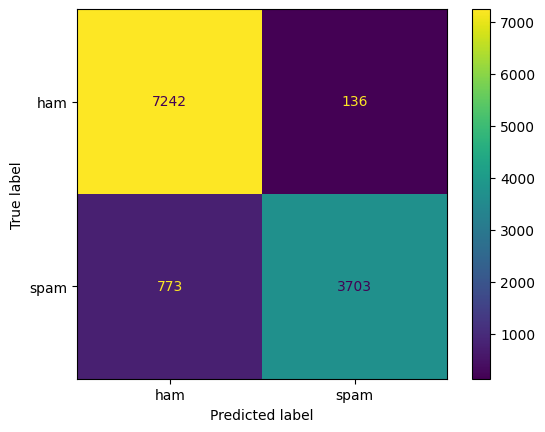

In [585]:
model = KNeighborsClassifier(n_neighbors=2, metric="cosine", n_jobs=-1)
model.fit(X_train3, Y_train3)


y_pred = [val_converter[x] for x in model.predict(X_test3)]
y_true = [val_converter[x] for x in Y_test3]


print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

## 5. XGBoost / LightGBM

In [624]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [625]:
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)


In [591]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss', 'cosine']

In [648]:
bst = lgb.LGBMClassifier(num_leaves=31, objective='binary', num_iterations=100, learning_rate=0.1, n_estimators=40)
# gbm = GridSearchCV(bst, {"learning_rate": [0.05, 0.1], "n_estimators": [40, 60, 80]}, cv=3)
# gbm = gbm.fit(X=X_train, y=Y_train,eval_metric='cosine')
# print(f"Best parameters found by grid search are: {gbm.best_params_}")

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 606, number of negative: 3853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15100
[LightGBM] [Info] Number of data points in the train set: 4459, number of used features: 503
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135905 -> initscore=-1.849727
[LightGBM] [Info] Start training from score -1.849727
Accuracy: 0.979372197309417
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       974
        spam       0.98      0.85      0.91       141

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



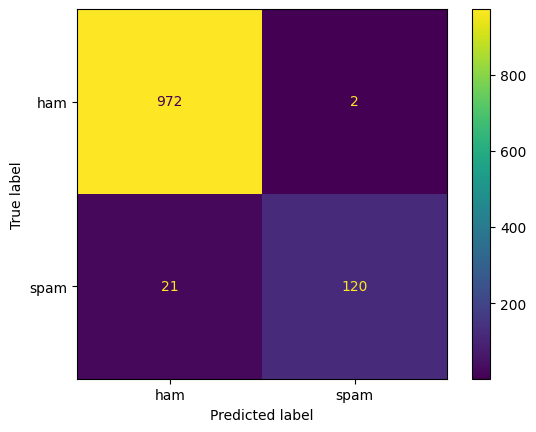

In [649]:
bst = bst.fit(X=X_train, y=Y_train,eval_metric='cosine')
y_pred = [val_converter[x] for x in bst.predict(X_test)]
y_true = [val_converter[x] for x in Y_test]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 22863, number of negative: 30830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625489
[LightGBM] [Info] Number of data points in the train set: 53693, number of used features: 4996
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.425810 -> initscore=-0.298968
[LightGBM] [Info] Start training from score -0.298968
Accuracy: 0.9282382490132759
              precision    recall  f1-score   support

         ham       0.99      0.93      0.96      4827
        spam       0.67      0.91      0.77       747

    accuracy                           0.93      5574
   macro avg       0.83      0.92      0.87      5574
weighted avg       0.94      0.93      0.93      5574



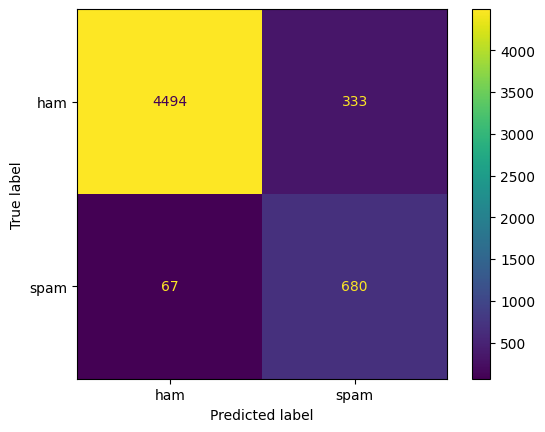

In [653]:
bst = lgb.LGBMClassifier(num_leaves=31, objective='binary', num_iterations=100, learning_rate=0.1, n_estimators=40)
# gbm = GridSearchCV(bst, {"learning_rate": [0.01, 0.05, 0.1], "n_estimators": [40, 60, 80, 100]}, cv=3)
# gbm = gbm.fit(X=X_train2, y=Y_train2,eval_metric='cosine')
# print(f"Best parameters found by grid search are: {gbm.best_params_}")

bst = bst.fit(X=X_train2, y=Y_train2,eval_metric='cosine')
y_pred = [val_converter[x] for x in bst.predict(X_test2)]
y_true = [val_converter[x] for x in Y_test2]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 18387, number of negative: 29026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552277
[LightGBM] [Info] Number of data points in the train set: 47413, number of used features: 4991
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387805 -> initscore=-0.456548
[LightGBM] [Info] Start training from score -0.456548
Accuracy: 0.9398515269107475
              precision    recall  f1-score   support

         ham       0.94      0.97      0.95      7378
        spam       0.95      0.89      0.92      4476

    accuracy                           0.94     11854
   macro avg       0.94      0.93      0.94     11854
weighted avg       0.94      0.94      0.94     11854



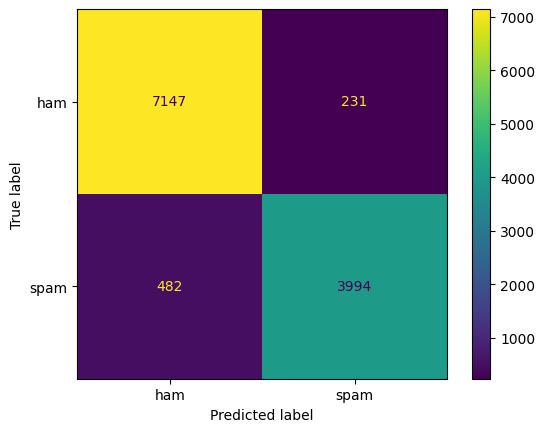

In [652]:
bst = lgb.LGBMClassifier(num_leaves=31, objective='binary', num_iterations=100, learning_rate=0.1, n_estimators=40)
# gbm = GridSearchCV(bst, {"learning_rate": [0.01, 0.05, 0.1], "n_estimators": [40, 60, 80, 100]}, cv=3)
# gbm = gbm.fit(X=X_train2, y=Y_train2,eval_metric='cosine')
# print(f"Best parameters found by grid search are: {gbm.best_params_}")

bst = bst.fit(X=X_train3, y=Y_train3,eval_metric='cosine')
y_pred = [val_converter[x] for x in bst.predict(X_test3)]
y_true = [val_converter[x] for x in Y_test3]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

In [664]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def xgboost_spam(x_train, y_train, x_test, y_test, verbose=1):

    # Initialize the XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(objective="binary:logistic")

    # Define hyperparameters and values to tune
    param_grid = {
        'max_depth': [5, 6, 7, 8],
        'eta': np.arange(0.05, 0.3, 0.05)
    }

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring="roc_auc", n_jobs=32,
                               cv=5, verbose=verbose)
    grid_search.fit(x_train, y_train)

    # Get the best hyperparameters
    best_max_depth = grid_search.best_params_['max_depth']
    best_eta = grid_search.best_params_['eta']

    final_xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                                      max_depth=best_max_depth,
                                      n_jobs=32,
                                      eta=best_eta,
                                      random_state=3137)
    final_xgb_clf.fit(x_train, y_train)

    y_pred = [val_converter[x] for x in final_xgb_clf.predict(x_test)]
    y_true = [val_converter[x] for x in y_test]

    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['ham', 'spam']).plot()

In [667]:
TOKENIZERS_PARALLELISM=False

Fitting 5 folds for each of 20 candidates, totalling 100 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Accuracy: 0.9748878923766816
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       974
        spam       0.98      0.82      0.89       141

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



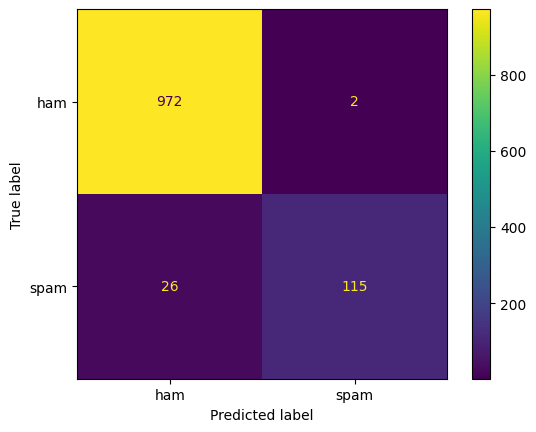

In [665]:
xgboost_spam(X_train, Y_train, X_test, Y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV 2/5] END ..............eta=0.1, max_depth=5;, score=0.984 total time=  56.3s
[CV 4/5] END ..............eta=0.1, max_depth=5;, score=0.952 total time= 1.0min
[CV 3/5] END ..............eta=0.1, max_depth=5;, score=0.977 total time= 1.0min
[CV 2/5] END .............eta=0.05, max_depth=5;, score=0.978 total time= 1.1min
[CV 1/5] END ..............eta=0.1, max_depth=5;, score=0.984 total time= 1.1min
[CV 1/5] END .............eta=0.05, max_depth=5;, score=0.976 total time= 1.2min
[CV 3/5] END .............eta=0.05, max_depth=5;, score=0.965 total time= 1.2min
[CV 4/5] END .............eta=0.05, max_depth=5;, score=0.949 total time= 1.2min
[CV 5/5] END ..............eta=0.1, max_depth=5;, score=0.667 total time= 1.2min
[CV 5/5] END .............eta=0.05, max_depth=5;, score=0.638 total time= 1.4min
[CV 2/5] END .............eta=0.05, max_depth=6;, score=0.980 total time= 1.5min
[CV 4/5] END .............eta=0.05, max_depth=6;, score=0.953 total time= 1.7min
[CV 3/5] END .............et

/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 5/5] END ..............eta=0.1, max_depth=6;, score=0.672 total time= 1.9min
[CV 4/5] END eta=0.15000000000000002, max_depth=5;, score=0.942 total time= 1.2min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 2/5] END ..............eta=0.1, max_depth=7;, score=0.987 total time= 2.0min
[CV 4/5] END .............eta=0.05, max_depth=8;, score=0.959 total time= 3.0min
[CV 3/5] END .............eta=0.05, max_depth=8;, score=0.973 total time= 3.0min
[CV 5/5] END eta=0.15000000000000002, max_depth=5;, score=0.681 total time= 1.3min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 1/5] END .............eta=0.05, max_depth=8;, score=0.984 total time= 3.1min
[CV 3/5] END ..............eta=0.1, max_depth=7;, score=0.980 total time= 2.2min
[CV 1/5] END ..............eta=0.1, max_depth=7;, score=0.987 total time= 2.2min
[CV 4/5] END ..............eta=0.1, max_depth=7;, score=0.952 total time= 2.2min
[CV 1/5] END eta=0.15000000000000002, max_depth=6;, score=0.989 total time= 1.6min
[CV 5/5] END .............eta=0.05, max_depth=8;, score=0.670 total time= 3.4min
[CV 5/5] END ..............eta=0.1, max_depth=7;, score=0.684 total time= 2.3min
[CV 2/5] END eta=0.15000000000000002, max_depth=6;, score=0.988 total time= 1.4min
[CV 2/5] END ..............eta=0.1, max_depth=8;, score=0.988 total time= 2.4min
[CV 3/5] END eta=0.15000000000000002, max_depth=6;, score=0.985 total time= 1.6min
[CV 1/5] END ..............eta=0.1, max_depth=8;, score=0.989 total time= 2.8min
[CV 4/5] END eta=0.15000000000000002, max_depth=6;, score=0.949 total time= 1.6min
[CV 4/5] END .......

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 5/5] END ..............eta=0.1, max_depth=8;, score=0.697 total time= 2.9min
[CV 3/5] END ..............eta=0.2, max_depth=5;, score=0.985 total time= 1.1min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 4/5] END ..............eta=0.2, max_depth=5;, score=0.949 total time= 1.2min
[CV 2/5] END eta=0.15000000000000002, max_depth=7;, score=0.990 total time= 1.8min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 5/5] END ..............eta=0.2, max_depth=5;, score=0.705 total time= 1.2min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 1/5] END eta=0.15000000000000002, max_depth=7;, score=0.990 total time= 2.0min
[CV 2/5] END ..............eta=0.2, max_depth=6;, score=0.990 total time= 1.3min
[CV 3/5] END eta=0.15000000000000002, max_depth=7;, score=0.988 total time= 2.0min
[CV 4/5] END eta=0.15000000000000002, max_depth=7;, score=0.948 total time= 2.0min
[CV 1/5] END ..............eta=0.2, max_depth=6;, score=0.990 total time= 1.5min
[CV 3/5] END ..............eta=0.2, max_depth=6;, score=0.987 total time= 1.5min
[CV 4/5] END ..............eta=0.2, max_depth=6;, score=0.949 total time= 1.5min
[CV 5/5] END eta=0.15000000000000002, max_depth=7;, score=0.715 total time= 2.1min
[CV 5/5] END ..............eta=0.2, max_depth=6;, score=0.712 total time= 1.6min
[CV 2/5] END eta=0.15000000000000002, max_depth=8;, score=0.990 total time= 2.2min
[CV 2/5] END ..............eta=0.2, max_depth=7;, score=0.990 total time= 1.6min
[CV 2/5] END .............eta=0.25, max_depth=5;, score=0.990 total time=  59.9s
[CV 1/5] END .....

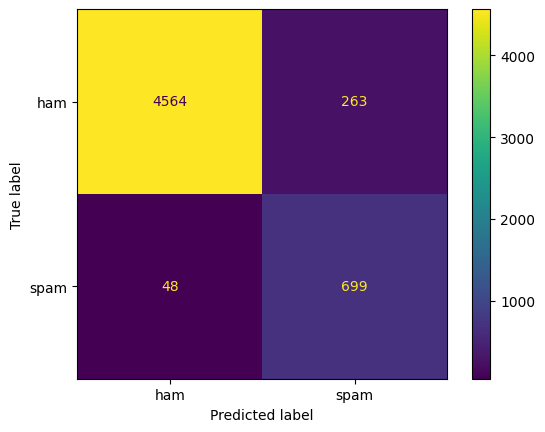

In [669]:
xgboost_spam(X_train2, Y_train2, X_test2, Y_test2, verbose=3)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 4/5] END ..............eta=0.1, max_depth=5;, score=0.975 total time=  53.6s
[CV 5/5] END ..............eta=0.1, max_depth=5;, score=0.967 total time=  53.9s
[CV 2/5] END ..............eta=0.1, max_depth=5;, score=0.970 total time=  54.0s
[CV 3/5] END ..............eta=0.1, max_depth=5;, score=0.971 total time=  54.2s


/Users/glebalexeev/Documents/jobs/CallBox/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after 

[CV 1/5] END ..............eta=0.1, max_depth=5;, score=0.970 total time=  55.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 3/5] END .............eta=0.05, max_depth=5;, score=0.956 total time= 1.0min
[CV 5/5] END .............eta=0.05, max_depth=5;, score=0.952 total time= 1.0min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 2/5] END .............eta=0.05, max_depth=5;, score=0.956 total time= 1.0min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 4/5] END .............eta=0.05, max_depth=5;, score=0.960 total time= 1.1min
[CV 1/5] END .............eta=0.05, max_depth=5;, score=0.955 total time= 1.1min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 4/5] END .............eta=0.05, max_depth=6;, score=0.966 total time= 1.5min
[CV 2/5] END .............eta=0.05, max_depth=6;, score=0.962 total time= 1.5min
[CV 1/5] END .............eta=0.05, max_depth=6;, score=0.961 total time= 1.5min
[CV 5/5] END .............eta=0.05, max_depth=6;, score=0.959 total time= 1.5min
[CV 3/5] END .............eta=0.05, max_depth=6;, score=0.962 total time= 1.5min
[CV 1/5] END .............eta=0.05, max_depth=7;, score=0.966 total time= 2.0min
[CV 3/5] END .............eta=0.05, max_depth=7;, score=0.967 total time= 2.0min
[CV 5/5] END .............eta=0.05, max_depth=7;, score=0.962 total time= 2.0min
[CV 2/5] END .............eta=0.05, max_depth=7;, score=0.967 total time= 2.0min
[CV 4/5] END .............eta=0.05, max_depth=7;, score=0.970 total time= 2.0min
[CV 1/5] END eta=0.15000000000000002, max_depth=5;, score=0.976 total time= 1.1min
[CV 2/5] END eta=0.15000000000000002, max_depth=5;, score=0.977 total time= 1.0min
[CV 1/5] END ...........

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 5/5] END eta=0.15000000000000002, max_depth=5;, score=0.974 total time= 1.1min
[CV 3/5] END .............eta=0.05, max_depth=8;, score=0.969 total time= 2.6min
[CV 5/5] END .............eta=0.05, max_depth=8;, score=0.967 total time= 2.6min
[CV 2/5] END .............eta=0.05, max_depth=8;, score=0.970 total time= 2.6min
[CV 1/5] END .............eta=0.05, max_depth=8;, score=0.969 total time= 2.6min
[CV 4/5] END .............eta=0.05, max_depth=8;, score=0.973 total time= 2.6min
[CV 1/5] END ..............eta=0.1, max_depth=7;, score=0.977 total time= 1.9min
[CV 3/5] END ..............eta=0.1, max_depth=7;, score=0.977 total time= 1.9min
[CV 2/5] END ..............eta=0.1, max_depth=7;, score=0.977 total time= 1.9min
[CV 2/5] END eta=0.15000000000000002, max_depth=6;, score=0.979 total time= 1.3min
[CV 4/5] END ..............eta=0.1, max_depth=7;, score=0.980 total time= 1.9min
[CV 1/5] END eta=0.15000000000000002, max_depth=6;, score=0.978 total time= 1.4min
[CV 5/5] END .........

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 2/5] END ..............eta=0.2, max_depth=5;, score=0.980 total time=  59.2s
[CV 1/5] END ..............eta=0.2, max_depth=5;, score=0.979 total time= 1.0min
[CV 5/5] END ..............eta=0.2, max_depth=5;, score=0.977 total time=  59.7s
[CV 1/5] END eta=0.15000000000000002, max_depth=7;, score=0.981 total time= 1.7min
[CV 2/5] END eta=0.15000000000000002, max_depth=7;, score=0.982 total time= 1.7min
[CV 3/5] END eta=0.15000000000000002, max_depth=7;, score=0.982 total time= 1.7min
[CV 4/5] END eta=0.15000000000000002, max_depth=7;, score=0.984 total time= 1.7min
[CV 2/5] END ..............eta=0.2, max_depth=6;, score=0.982 total time= 1.3min
[CV 1/5] END ..............eta=0.2, max_depth=6;, score=0.982 total time= 1.3min
[CV 3/5] END ..............eta=0.2, max_depth=6;, score=0.983 total time= 1.3min
[CV 5/5] END eta=0.15000000000000002, max_depth=7;, score=0.979 total time= 1.7min
[CV 5/5] END ..............eta=0.2, max_depth=6;, score=0.980 total time= 1.3min
[CV 4/5] END .....

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 1/5] END ..............eta=0.2, max_depth=7;, score=0.983 total time= 1.6min
[CV 3/5] END eta=0.15000000000000002, max_depth=8;, score=0.983 total time= 2.0min
[CV 2/5] END ..............eta=0.2, max_depth=7;, score=0.984 total time= 1.6min
[CV 2/5] END eta=0.15000000000000002, max_depth=8;, score=0.983 total time= 2.1min
[CV 4/5] END ..............eta=0.2, max_depth=7;, score=0.986 total time= 1.6min
[CV 3/5] END ..............eta=0.2, max_depth=7;, score=0.984 total time= 1.6min
[CV 4/5] END eta=0.15000000000000002, max_depth=8;, score=0.985 total time= 2.1min
[CV 1/5] END eta=0.15000000000000002, max_depth=8;, score=0.983 total time= 2.1min
[CV 3/5] END .............eta=0.25, max_depth=5;, score=0.982 total time=  57.7s
[CV 5/5] END .............eta=0.25, max_depth=5;, score=0.979 total time=  57.8s
[CV 4/5] END .............eta=0.25, max_depth=5;, score=0.984 total time=  58.1s
[CV 5/5] END eta=0.15000000000000002, max_depth=8;, score=0.981 total time= 2.0min
[CV 1/5] END .....

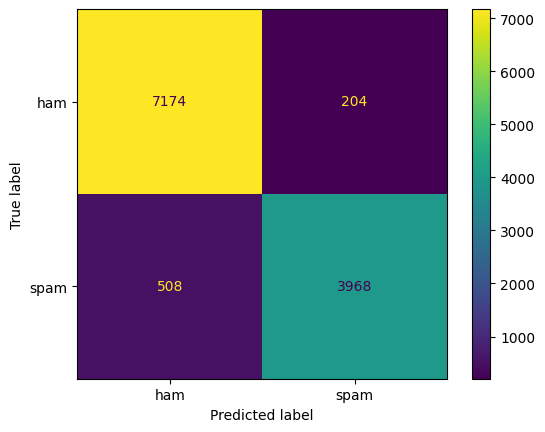

In [670]:
xgboost_spam(X_train3, Y_train3, X_test3, Y_test3, verbose=3)

## 6. Google Gemini approach with million context window

In [674]:
import google.generativeai as genai
import os

genai.configure(api_key=API_KEY)

In [685]:
# import os
# import google.generativeai as genai
# from google.generativeai.types import HarmCategory, HarmBlockThreshold
# from google.generativeai import caching
# import datetime
# import time

# data_file = genai.upload_file(path='data/Spam_SMS.csv')

# # Wait for the file to finish processing
# while data_file.state.name == 'PROCESSING':
#   print('Waiting for the data to be processed.')
#   time.sleep(2)
#   data_file = genai.get_file(data_file.name)

# print(f'Data processing complete: {data_file.uri}')


# # Create a cache with a 5 minute TTL
# cache = caching.CachedContent.create(
#     model='models/gemini-1.5-flash-001',
#     display_name='data shenanigans',
#     tools='code_execution',
#     system_instruction=(
# """
# You are an expert data modeler, and data scientist. 
# Your job is to build a machine learning model that best classifies a message as spam or not spam. 
# You will be given a data set by the user, and you will have to split it into a training and a testing set. 
# You should also select a metric that best works with the data. 
# Generally, cosine distance is a great choice (although you probably know more).
# It will be your job to choose an algorithm that would best get the job done based on the structure of the data. 
# Retrace your steps and explain your thought process on why you should use a certain algorithm versus another. 
# Then, generate annotated code trained on said model to predict any future incoming text. 
# You will be handsomely rewarded, and I will tip you $100 extra dollars if you do a good job!
# """  
#     ),
#     contents=[data_file],
#     ttl=datetime.timedelta(minutes=5),
# )

# # Construct a GenerativeModel which uses the created cache.
# model = genai.GenerativeModel.from_cached_content(cached_content=cache, safety_settings={
#         HarmCategory.Dangerous: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     })

# # Query the model
# response = model.generate_content(["Generate the code necessary for me to be able to classify this data"], safety_settings=None, stream=True)

# for chunk in response:
#     print(chunk.text)

# print(response.usage_metadata)

# print(response.text)


## 7. Using LLM: Custom Fine-tuned Roberta Model

See  my [huggingFace page](https://huggingface.co/ggrizzly/roBERTa-spam-detection) for it.

TL;DR:
- Accuracy: ~95%
- Fine-tuned roBERTa model
- Trained on enron and telegram
- Tested on SMS set

## Conclusions

Different models performed better with different data combinations...

For example, KNN / Multimodal Naive Bayes worked best with the original data, while it did worst in the full split (telegram, enron vs sms) (which makes sense).

Light GBM did the same except telegram+enron training data vs sms performed better than an even split of all 3.

In general though, they're all relatively close in accuracy (95%-98%).

## Resources

I definitely used a lot of different resources for this, and most of them are linked in the [huggingFace page](https://huggingface.co/ggrizzly/roBERTa-spam-detection) page. However, for sake of conversation here are some sourcees of information.
- huggingFace for RobertaTutorial found [here](https://huggingface.co/docs/transformers/main/en/model_doc/roberta#resources)
- inspiration for using roberta in the first place: [link](https://huggingface.co/mshenoda/roberta-spam)
- googleCollab [link](https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb) for instructions on roberta from huggingface
- all code relating to Multinominal Naive Bayes inspired by other kaggler approaches, but done uniquely through my own data approach
- all code generated by me (no copilot was used for this task)
- all code found here, if found online, was used in guides / resources / documentation from the packages themselves

## Bonus: (Mis)Anthropic Approach
Instead of thinking about "accuracy" metrics for the dataset, we should instead think about the market: who is our target audience? Who is this for?

This final approach targets a very specific (untapped, I would argue) population group: asocial, antisocial and misanthropic people.

For this market, this approach correctly assigns (with 100% accuracy!!!) any text received to be automatically spam.

None of these people want to look at their SMS texts, let alone "talk" with people.

In [37]:
def classify(msg):
    return "spam"

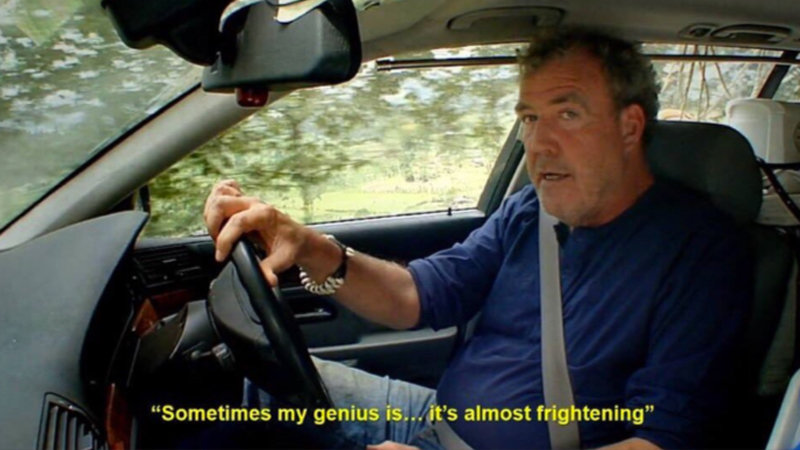

In [38]:
from IPython.display import Image
Image(filename='genius.jpg') 